In [ ]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))
from lod.voxelization.voxel_methods_others import AggregationMethod
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
data_dir = "/ssd1/rajrup/Project/livogs_mv/results"
seq_name = "171026_pose3_no_ground"
trained_iter = 10000
trained_voxel_size = 0.001
allowable_voxel_sizes = [0.01, 0.025, 0.05, 0.1]

frame_id = 580

exp_names = [
    f"nogop_voxel_size_{trained_voxel_size}_freeze_means_voxelized_to_voxel_size_{voxel_size}"
    for voxel_size in allowable_voxel_sizes
]

aggregate_methods = [
    AggregationMethod.geometric,
    AggregationMethod.adaptive,
    AggregationMethod.covariance_weighted,  # Mathematical covariance combination
    AggregationMethod.gaussian_mixture,  # Proper Gaussian mixture reduction
    AggregationMethod.opacity_preserved,  # Focus on opacity preservation
    AggregationMethod.hybrid_dominant,  # Hybrid approach
    AggregationMethod.volume_weighted,  # Volume-based weighting
]

aggregate_methods_rename = [
    "Geometric",
    "Adaptive",
    "Covariance Weighted",
    "Gaussian Mixture",
    "Opacity Preserved",
    "Hybrid Dominant",
    "Volume Weighted",
]

In [4]:
result_dict = {}
for voxel_size, exp_name in zip(allowable_voxel_sizes, exp_names):
    result_dict[voxel_size] = {}
    for aggregate_method in aggregate_methods:
        result_dir = os.path.join(
            data_dir, exp_name, seq_name, f"{frame_id}", f"{aggregate_method}"
        )

        result_dict[voxel_size][aggregate_method] = {
            "step": [],
            "psnr": [],
            "ssim": [],
            "lpips": [],
            "time": {},
        }

        for step in range(0, trained_iter, 1000):
            if step == 0:
                path = os.path.join(result_dir, "stats", f"val_step{step:04d}.json")
            else:
                path = os.path.join(result_dir, "stats", f"val_step{step-1:04d}.json")
            with open(path, "r") as f:
                data = json.load(f)

            result_dict[voxel_size][aggregate_method]["step"].append(step)
            result_dict[voxel_size][aggregate_method]["psnr"].append(data["psnr"])
            result_dict[voxel_size][aggregate_method]["ssim"].append(data["ssim"])
            result_dict[voxel_size][aggregate_method]["lpips"].append(data["lpips"])

        path = os.path.join(result_dir, "voxel_stats.json")
        with open(path, "r") as f:
            data = json.load(f)

        result_dict[voxel_size][aggregate_method]["time"] = data

In [ ]:
result_dict

{0.01: {'geometric': {'step': [0,
    1000,
    2000,
    3000,
    4000,
    5000,
    6000,
    7000,
    8000,
    9000],
   'psnr': [32.188106536865234,
    35.12940979003906,
    36.20623779296875,
    37.6577262878418,
    39.31370162963867,
    39.75047302246094,
    40.042701721191406,
    40.2607536315918,
    40.453853607177734,
    40.603939056396484],
   'ssim': [0.986423134803772,
    0.9912296533584595,
    0.992138683795929,
    0.993851363658905,
    0.9956187605857849,
    0.9958076477050781,
    0.9959395527839661,
    0.9960250854492188,
    0.9960910677909851,
    0.9961380362510681],
   'lpips': [0.051587607711553574,
    0.048835668712854385,
    0.04631270095705986,
    0.042270537465810776,
    0.04165235906839371,
    0.041299968957901,
    0.041028596460819244,
    0.040821004658937454,
    0.040650077164173126,
    0.040516067296266556],
   'time': {'voxel_creation': 1420.9036827087402,
    'attribute_aggregation': 2317.173480987549,
    'model_creation': 198

In [6]:
exp_names = [
    f"nogop_voxel_size_{voxel_size}_freeze_means"
    for voxel_size in allowable_voxel_sizes
]
upperbound_quality_dict = {}
for voxel_size, exp_name in zip(allowable_voxel_sizes, exp_names):
    upperbound_quality_dict[voxel_size] = {
        "psnr": 0.0,
        "ssim": 0.0,
        "lpips": 0.0,
    }
    result_dir = os.path.join(data_dir, exp_name, seq_name, f"{frame_id}")
    path = os.path.join(result_dir, "stats", f"val_step{trained_iter-1:04d}.json")
    with open(path, "r") as f:
        data = json.load(f)
    upperbound_quality_dict[voxel_size]["psnr"] = data["psnr"]
    upperbound_quality_dict[voxel_size]["ssim"] = data["ssim"]
    upperbound_quality_dict[voxel_size]["lpips"] = data["lpips"]

In [7]:
upperbound_quality_dict

{0.01: {'psnr': 39.39711380004883,
  'ssim': 0.9957149624824524,
  'lpips': 0.03945155069231987},
 0.025: {'psnr': 34.245235443115234,
  'ssim': 0.9902920126914978,
  'lpips': 0.054761726409196854},
 0.05: {'psnr': 31.22999382019043,
  'ssim': 0.9814727902412415,
  'lpips': 0.08608061075210571},
 0.1: {'psnr': 28.909936904907227,
  'ssim': 0.9733778238296509,
  'lpips': 0.12188418954610825}}

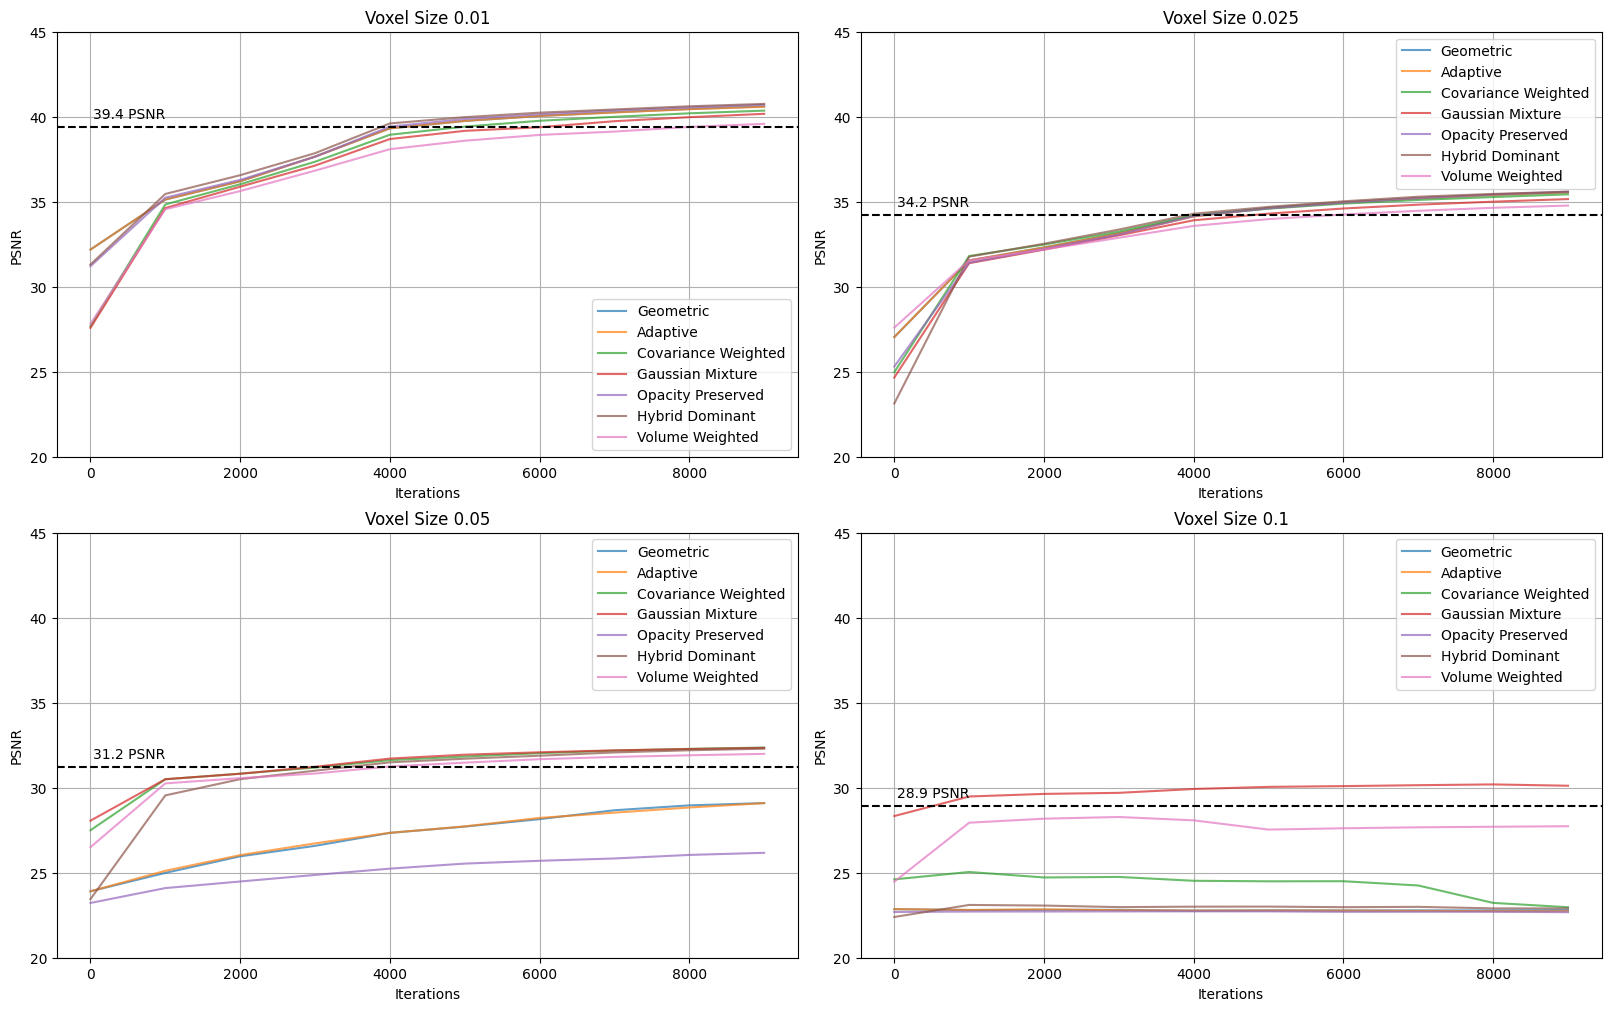

In [8]:
# Create figure with subplots for each metric
fig, axes = plt.subplots(2, 2, figsize=(16, 10), constrained_layout=True)
metrics = ["psnr"]
metric_names = ["PSNR"]
# colors = ["blue", "red"]  # One color for each threshold

for i, voxel_size in enumerate(allowable_voxel_sizes):
    if i < 2:
        ax = axes[0, i]
    else:
        ax = axes[1, i - 2]
    for metric, metric_name in zip(metrics, metric_names):
        for method, method_name in zip(aggregate_methods, aggregate_methods_rename):
            # Plot for each frame
            steps = result_dict[voxel_size][method]["step"]
            values = result_dict[voxel_size][method][metric]
            ax.plot(
                steps,
                values,
                alpha=0.7,
                label=f"{method_name}",
            )

        ax.set_xlabel("Iterations")
        ax.set_ylabel(metric_name)
        ax.grid(True)
        ax.legend()
        ax.set_title(f"Voxel Size {voxel_size}")
        ax.set_ylim(20, 45)

        # Add upper bound quality
        ax.axhline(
            upperbound_quality_dict[voxel_size][metric],
            color="black",
            linestyle="--",
            label="Upper Bound Quality",
        )
        # Add upper bound quality text
        ax.text(
            1000,
            upperbound_quality_dict[voxel_size][metric] + 0.5,
            f"{upperbound_quality_dict[voxel_size][metric]:.1f} PSNR",
            ha="right",
        )
plt.show()

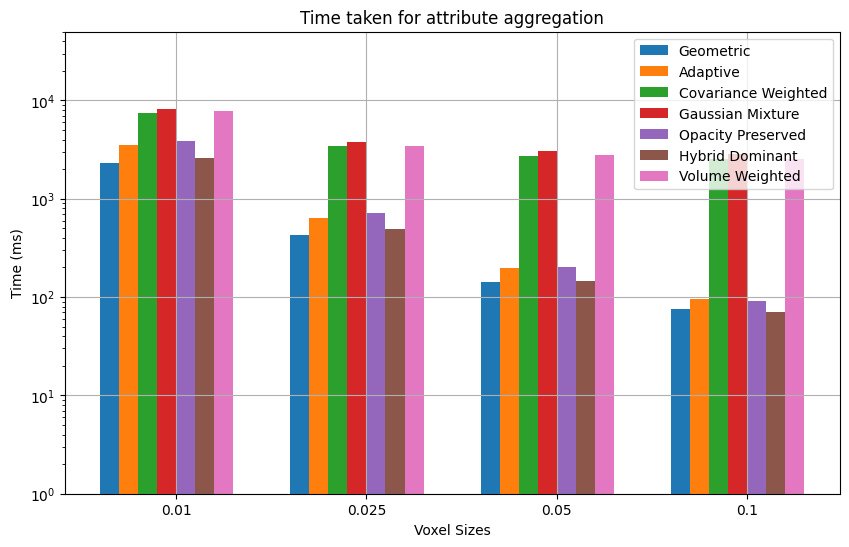

In [9]:
# Create figure with subplots for each metric
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

x = np.arange(len(allowable_voxel_sizes))
width = 0.1
for j, (method, method_name) in enumerate(
    zip(aggregate_methods, aggregate_methods_rename)
):
    aggergation_times = []
    for i, voxel_size in enumerate(allowable_voxel_sizes):

        aggergation_time = result_dict[voxel_size][method]["time"][
            "attribute_aggregation"
        ]
        aggergation_times.append(aggergation_time)

    # Bar plot for aggregation time
    ax.bar(
        x + j * width,
        aggergation_times,
        width,
        label=method_name,
    )

    ax.set_xlabel("Voxel Sizes")
    ax.set_ylabel("Time (ms)")
    ax.set_xticks(x + 3.5 * width)
    ax.set_xticklabels(allowable_voxel_sizes)
    ax.grid(True)
    ax.legend()
    ax.set_yscale("log")
    ax.set_title(f"Time taken for attribute aggregation")
    ax.set_ylim(1, 50000)
plt.show()